In [7]:
import pandas as pd
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords

## Loading data

In [8]:
df = pd.read_csv("../spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [10]:
max(df['message_len'])

171

## EDA (look about the target distribution)

In [11]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747], dtype=int64)

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color="blue"
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color="grey"
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [13]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color="blue",
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color="grey",
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

## Data Pre-Processing

### Cleaning the corpus

In [14]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [15]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


In [16]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


### Stemming (abjustable => abjust) / Lematization (was => to(be))

In [17]:
stemmer = nltk.SnowballStemmer("english") #check with other stemmer

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [18]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## All together

In [19]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [20]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## Target enconding

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


## Tokens visualization

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from wordcloud import WordCloud

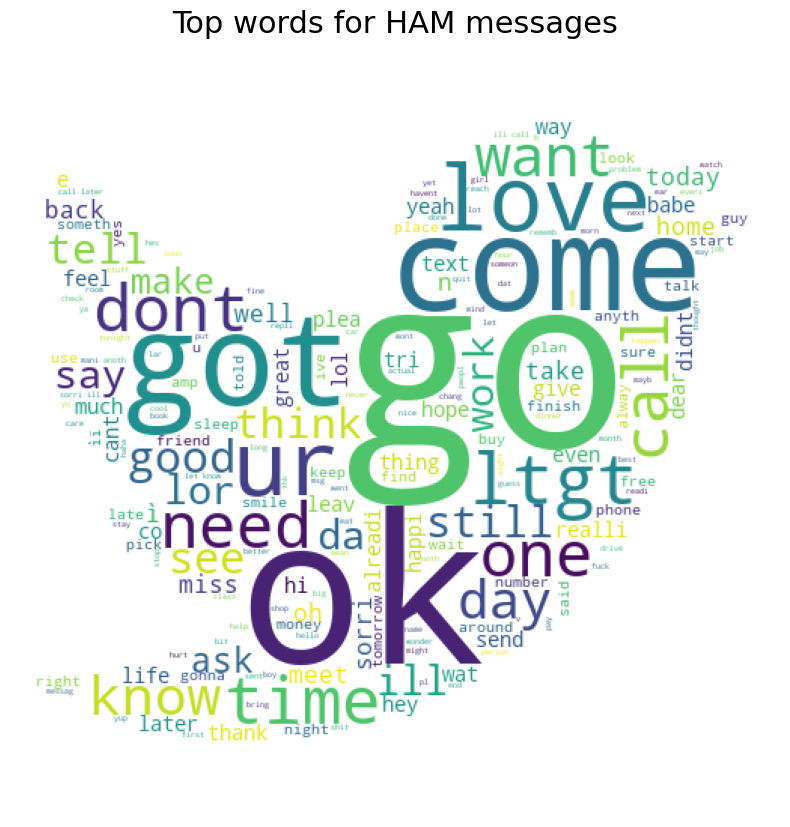

In [23]:
twitter_mask = np.array(Image.open('image.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

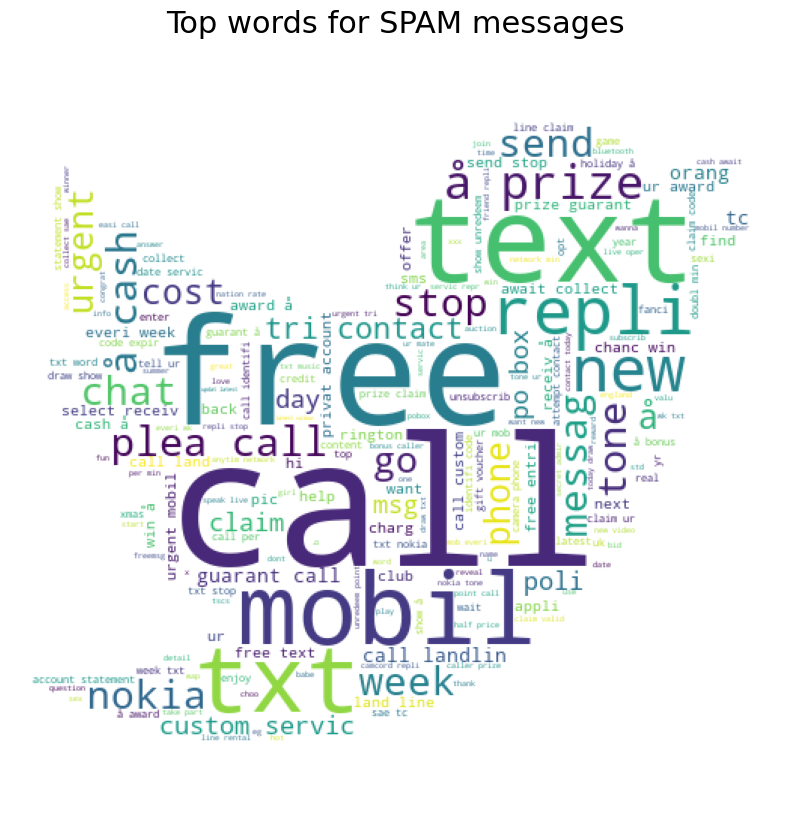

In [24]:
twitter_mask = np.array(Image.open('image.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

## Vectorization

In [25]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [26]:
x

0       go jurong point crazi avail bugi n great world...
1                                     ok lar joke wif oni
2       free entri  wkli comp win fa cup final tkts  m...
3                             dun say ear hor alreadi say
4               nah dont think goe usf live around though
                              ...                        
5567     time tri  contact å£ pound prize  claim easi ...
5568                              ì b go esplanad fr home
5569                             piti  mood soani suggest
5570    guy bitch act like id interest buy someth el n...
5571                                       rofl true name
Name: message_clean, Length: 5572, dtype: object

In [27]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [28]:
x_train

4281                                                 call
585                 tell headach want use  hour sick time
4545    never tri alon take weight tear come ur heart ...
3034    rajipl favour pls convey birthday wish nimya p...
2758                                     time iû÷m prob 
                              ...                        
3772           came hostel go sleep plz call class hrishi
5191                                 sorri ill call later
5226                   prabhaim sorydarealyfrm heart sori
5390                                 nt joke serious told
860                                           work go min
Name: message_clean, Length: 4179, dtype: object

In [29]:
x_train[:4][4545]

'never tri alon take weight tear come ur heart fall ur eye alway rememb stupid friend share bslvyl'

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [31]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [32]:
type(x_test_dtm)

scipy.sparse._csr.csr_matrix

In [33]:
x_train_dtm.toarray()[0]


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Tunning CountVectorizer

In [34]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100) #think about ngram_range.

## TF-IDF

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [36]:
type(x_train_tfidf)

scipy.sparse._csr.csr_matrix

## Word Embeddings: GloVe

In [37]:
texts = df['message_clean']
target = df['target_encoded']

In [38]:
from keras_preprocessing.text import Tokenizer 

In [39]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6726

In [40]:
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize

In [41]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6724, 1002, 6725, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]])

In [42]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt',encoding='utf-8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [43]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Modeling

### Naive Bayes DTM

In [44]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [45]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

def conf_matrix(confusion_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot()

0.9784637473079684


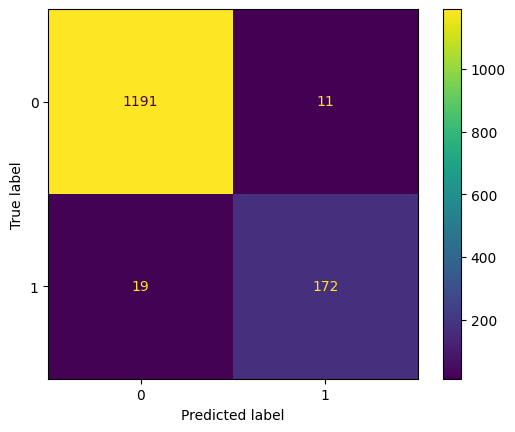

In [47]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

In [48]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.974296765425861

### Naive Bayes TF-IDF

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

0.9597989949748744


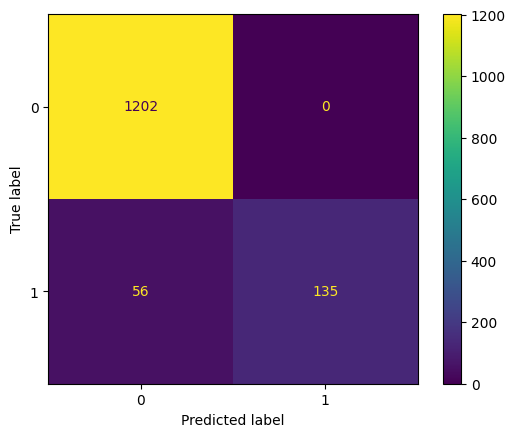

In [50]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

### XGBoost

In [51]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

Train: 0.9830102895429529
Test: 0.9641062455132807


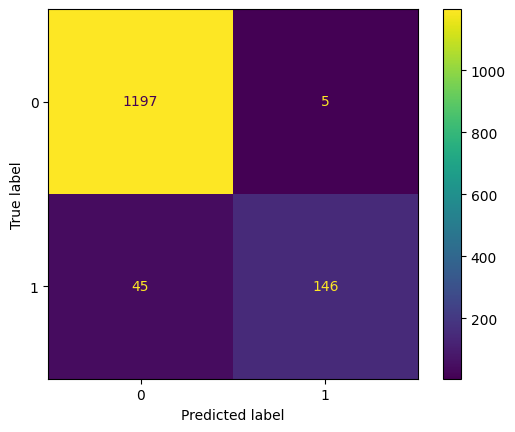

In [52]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

### Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier()

In [54]:
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', RandomForestClassifier(
        n_estimators=100
    ))
])

Train: 0.9995214166068438
Test: 0.9720028715003589


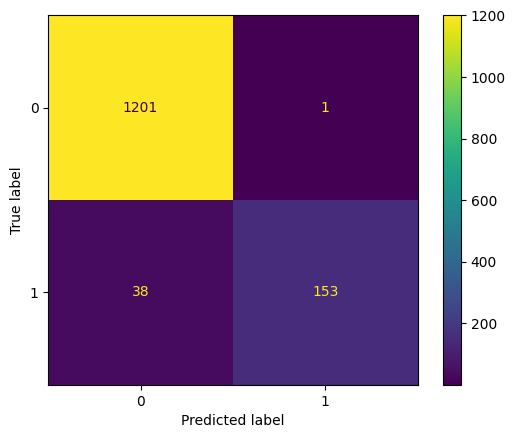

In [55]:
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

## LSTM

## Bert

## Test

In [56]:
emails = ['WARNING: (Criminal Investigation Division) I.R.S is filing lawsuit against you, for more information call on +1 7038798780 on urgent basis, Otherwise your arrest warrant will be forwarded to your local police department and your property and bank accounts and social benifits will be frozen by government.']

In [57]:
emails = [preprocess_data(text) for text in emails]

In [58]:
emails = pd.Series(emails)
emails

0    warn crimin investig divis ir file lawsuit inf...
dtype: object

In [59]:
pipe.predict(emails)

array([0])